In [19]:
%reload_ext autoreload
%autoreload 2

import os, sys

import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib as mpl

CWD = os.path.abspath(os.path.curdir)
print("CWD: '{}'".format(CWD))

ODIR = os.path.join(CWD, "output", "")
if not os.path.exists(ODIR):
    os.makedirs(ODIR)
    print("Created output directory: '{}'".format(ODIR))

par_dir = os.path.join(CWD, os.path.pardir)
if par_dir not in sys.path:
    sys.path.append(par_dir)
    print("Added parent directory: '{}'".format(par_dir))
    
import bhem
import bhem.basics
from bhem.constants import MSOL, H_PLNK, K_BLTZ, SPLC

np.seterr(over='ignore');

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times']})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})

FS_TITLE = 20
FS_LABEL = 16

plt.rcParams.update({'axes.titlesize': FS_TITLE})
plt.rcParams.update({'axes.labelsize': FS_LABEL})
plt.rcParams.update({'xtick.labelsize': FS_LABEL})
plt.rcParams.update({'ytick.labelsize': FS_LABEL})

## Parameters

In [4]:
MASS = 1e7 * MSOL
FEDD = 0.1

### Derived

In [5]:
mdot = bhem.basics.eddington_accretion(MASS)
rsch = bhem.basics.radius_schwarzschild(MASS)
rads = np.logspace(np.log10(6), 4, 200) * rsch
freqs = np.logspace(10, 18, 120)

## Disk Primitives Profiles

In [6]:
temp = bhem.basics.temperature_profile(MASS, mdot, rads)

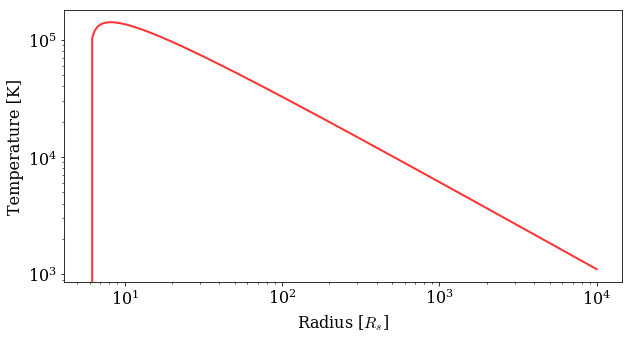

In [7]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.set(xscale='log', xlabel='Radius [$R_s$]', yscale='log', ylabel='Temperature [K]')

ax.plot(rads/rsch, temp, 'r-', lw=2.0, alpha=0.8)
plt.show()

## Blackbody Spectrum

In [22]:
# erg/s/Hz/cm^2/steradian
bb_spec_rad = bhem.basics.blackbody_spectral_radiance(MASS, mdot, rads[:, np.newaxis], freqs[np.newaxis, :])

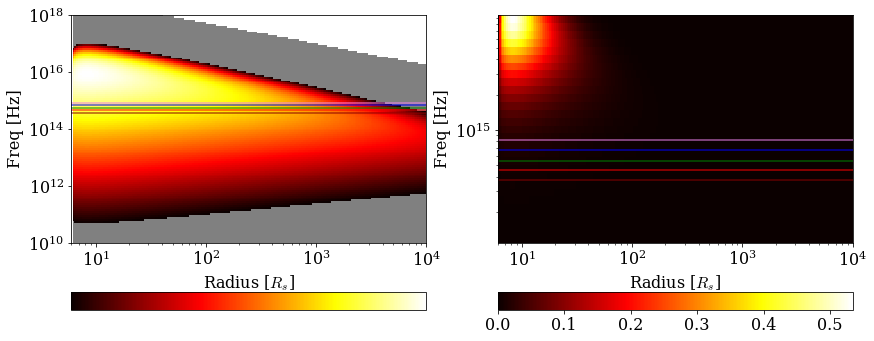

In [9]:
xx, yy = np.meshgrid(rads, freqs)

norm = mpl.colors.LogNorm(vmin=1e-10, vmax=np.max(bb_spec_rad))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='hot')
smap.cmap.set_under('0.5')

fig, axes = plt.subplots(figsize=[14, 6], ncols=2)
for ax in axes:
    ax.set(xscale='log', xlabel='Radius [$R_s$]', yscale='log', ylabel='Freq [Hz]')
    for nn, band in bhem.constants.BANDS.items():
        ax.axhline(band.freq, color=band.color, lw=2.0, alpha=0.5)

pcm = axes[0].pcolormesh(xx/rsch, yy, bb_spec_rad.T, norm=norm, cmap=smap.cmap)
plt.colorbar(pcm, ax=axes[0], orientation='horizontal')

finds = (1e14 < freqs) & (freqs < 1e16)

norm = mpl.colors.Normalize(0.0, np.max(bb_spec_rad[:, finds]))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='hot')
pcm = axes[1].pcolormesh(xx[finds, :]/rsch, yy[finds, :], bb_spec_rad[:, finds].T, norm=norm, cmap=smap.cmap)
plt.colorbar(pcm, ax=axes[1], orientation='horizontal')

plt.show()

In [10]:
annul = np.pi * (np.square(rads[1:]) - np.square(rads[:-1]))
ave_spec = 0.5 * (bb_spec_rad[1:] + bb_spec_rad[:-1])
bb_spec = 4.0*np.pi * np.sum(ave_spec * annul[:, np.newaxis], axis=0)

In [23]:
bb_lum = bhem.basics.blackbody_spectral_luminosity(MASS, mdot, freqs)

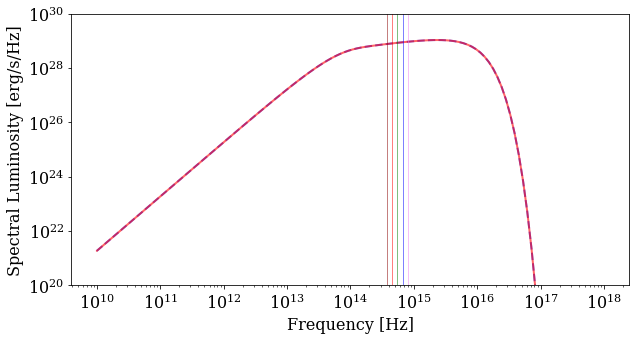

In [21]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.set(xscale='log', xlabel='Frequency [Hz]',
       yscale='log', ylabel='Spectral Luminosity [erg/s/Hz]', ylim=[1e20, 1e30])

ax.plot(freqs, bb_spec, 'b-', lw=2.0, alpha=0.6, ls='--')
ax.plot(freqs, bb_lum, 'r-', lw=2.0, alpha=0.6)

for nn, band in bhem.constants.BANDS.items():
    ax.axvline(band.freq, color=band.color, lw=1.0, alpha=0.5)

plt.show()